As the name of the file indicates, here the tests for the local operator splitting technique for a single source and a coarse mesh is done. Several off-centering tests are included, and the validation is made with two "point-source" schemes that are the Peaceman coupling model [D.W.Peaceman, 1978], and the full Solution Splitting model [Gjerde et al., 2019 ENSAIM]

In [28]:
import numpy as np 
import matplotlib.pyplot as plt
from module_2D_coupling_FV_nogrid import * 
import reconst_and_test_module as post
import random 
import scipy as sp
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tabulate import tabulate

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.rcParams['font.size'] = '20'

def get_plots_through_sources(phi_mat, SS_phi_mat,pos_s, rec_x,rec_y, orig_y):
    c=0
    vline=(orig_y[1:]+orig_y[:-1])/2
    for i in pos_s:
        pos=coord_to_pos(rec_x, rec_y, i)
        pos_x=int(pos%len(rec_x))
        plt.plot(rec_y, phi_mat[:,pos_x], label="coupling")
        plt.plot(rec_y, SS_phi_mat[:,pos_x], label="SS validation")
        plt.title("Concentration plot passing through source {}".format(c))
        plt.xlabel("position y ($\mu m$)")
        plt.ylabel("$\phi [kg m^{-1}]$")
        plt.axvline(x=i[1], color='r')
        for xc in vline:
            plt.axvline(x=xc, color='k', linestyle='--')
    
        plt.legend()
        plt.show()
        
def get_plots_through_sources_peaceman(phi_mat,peaceman,pos_s, rec_x,rec_y, orig_y):
    c=0
    vline=(orig_y[1:]+orig_y[:-1])/2
    for i in pos_s:
        pos=coord_to_pos(rec_x, rec_y, i)
        pos_x=int(pos%len(rec_x))
        plt.plot(rec_y, phi_mat[:,pos_x], label="coupling")
        plt.scatter(rec_y, peaceman[:,pos_x], label="Peaceman")
        plt.plot()
        plt.axvline(x=i[1], color='r')
        for xc in vline:
            plt.axvline(x=xc, color='k', linestyle='--')
        plt.title("Concentration plot passing through source {}".format(c))
        plt.xlabel("position y ($\mu m$)")
        plt.ylabel("$\phi [kg m^{-1}]$")
        plt.legend()
        plt.show()
        c+=1

#0-Set up the sources
#1-Set up the domain
D=1
L=5
cells=5
h_ss=L/cells
#ratio=int(np.max((h_ss/0.1,6)))
ratio=20
#Rv=np.exp(-2*np.pi)*h_ss
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)

In [29]:
ratio=20

directness= 2


Text(0.5, 0, 'x ($\\mu m$)')

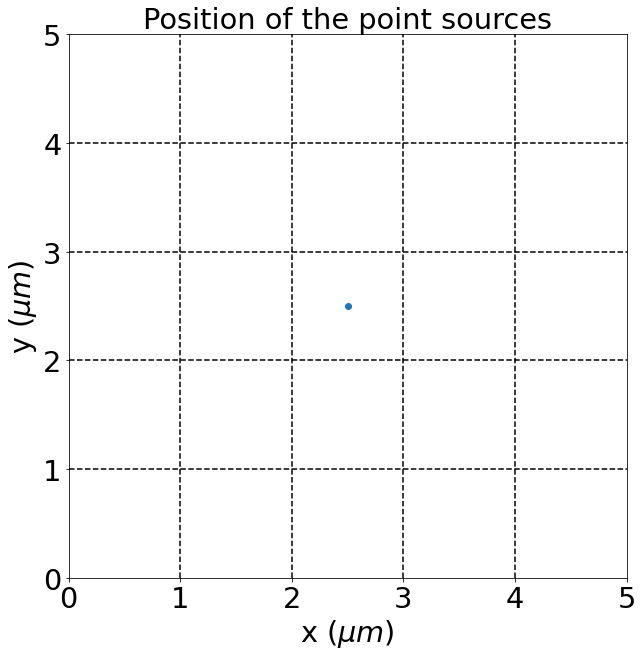

In [30]:
validation=True
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(np.around(L/h_ss)))
y_ss=x_ss
directness=int(np.around(L/(3*h_ss)))
print("directness=", directness)
#pos_s=np.array([[x_ss[2], y_ss[2]],[x_ss[4], y_ss[4]]])
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[2,2]])-np.array([0.25,0.25])
#pos_s/=2
#pos_s=np.array([[1.25,1.25],[1.25,1.75], [1.75,1.75],[1.75,1.25]])
#pos_s=np.array([[4.3,4.3],[4.3,5.5], [3.5,4.5],[3.5,3.5]])


pos_s=np.array([[0.5,0.5]])*L
S=len(pos_s)
vline=(y_ss[1:]+x_ss[:-1])/2
plt.scatter(pos_s[:,0], pos_s[:,1])
plt.title("Position of the point sources")
for xc in vline:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in vline:
    plt.axhline(y=xc, color='k', linestyle='--')
plt.xlim([0,L])
plt.ylim([0,L])
plt.ylabel("y ($\mu m$)")
plt.xlabel("x ($\mu m$)")

In [31]:
t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
t.pos_arrays()
t.initialize_matrices()
M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
t.B[-S:]=np.ones(S)*C0
#t.B[-np.random.randint(0,S,int(S/2))]=0
sol=np.linalg.solve(M, t.B)
phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
phi_q=sol[-S:]

# =============================================================================
# m=real_NN_rec(t.x, t.y, sol[:-len(pos_s)], t.pos_s, t.s_blocks, sol[-len(pos_s):], ratio, t.h, 1, t.Rv)
# m.add_singular(1)
# fin_rec=m.add_singular(1)+m.rec
# plt.imshow(fin_rec, origin='lower'); plt.colorbar()
# plt.show()
# print(fin_rec[:,-1])
# =============================================================================

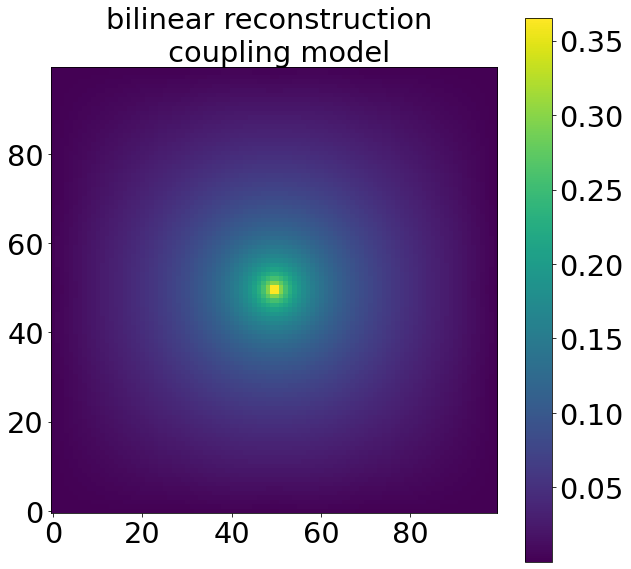

In [32]:
#Reconstruction microscopic field
#pdb.set_trace()
a=post.reconstruction_sans_flux(sol, t, L,ratio, directness)
p=a.reconstruction()   
a.reconstruction_boundaries(np.array([0,0,0,0]))
a.rec_corners()
plt.imshow(a.rec_final, origin='lower')
plt.title("bilinear reconstruction \n coupling model")
plt.colorbar(); plt.show()



In [33]:
#Validation Solution Splitting
SS=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D, L)
v_SS=SS.solve_problem(t.B[-S:])
phi_SS=SS.reconstruct(np.ndarray.flatten(v_SS), SS.phi_q)


[0.52925826]


COMPARISON WITH SOLUTION SPLITTING REFINED

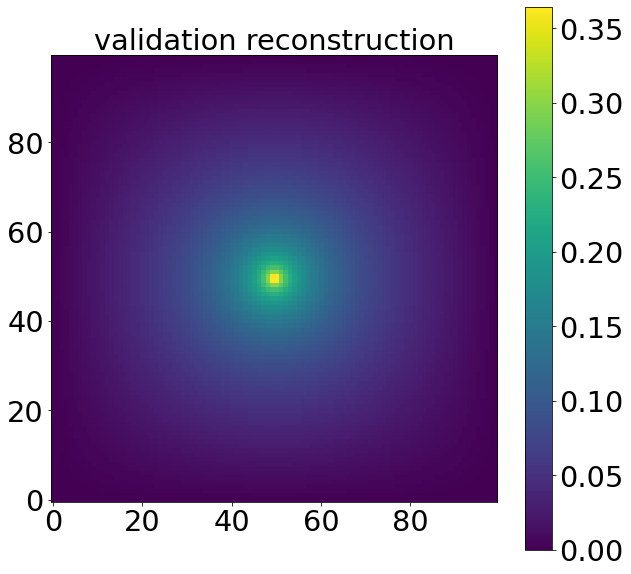

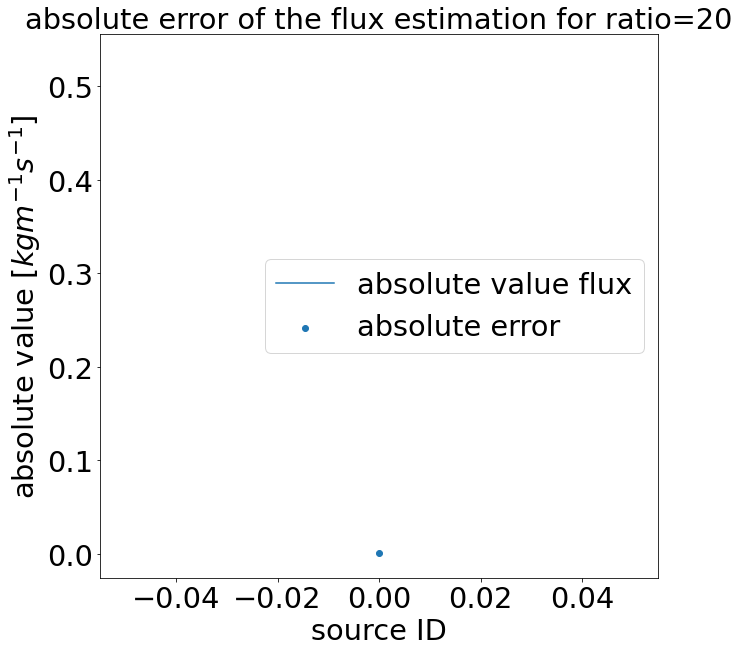

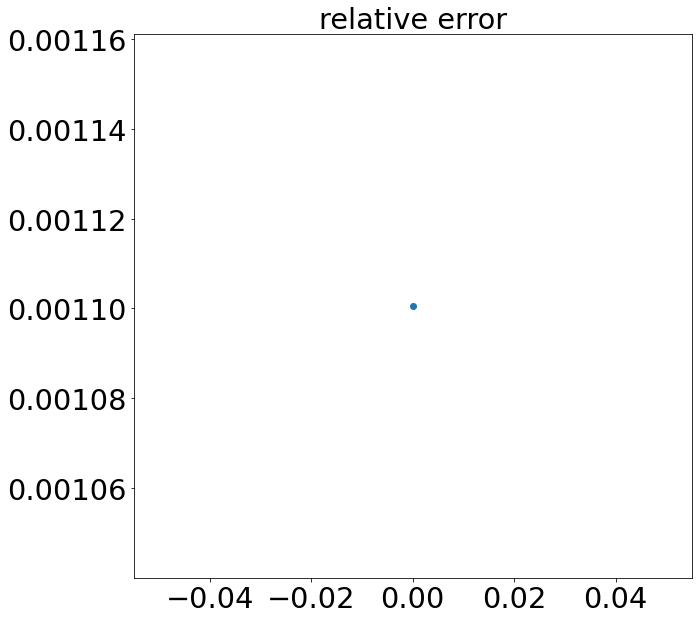

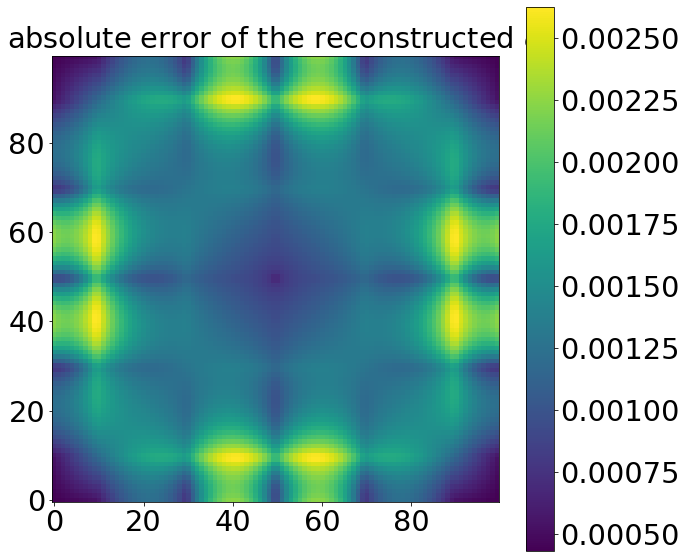

In [34]:
plt.imshow(phi_SS, origin='lower')
plt.title("validation reconstruction")
plt.colorbar()
plt.show()



plt.scatter(np.arange(len(SS.phi_q)),np.abs(SS.phi_q-phi_q), label="absolute error")
plt.plot(SS.phi_q, label="absolute value flux")
plt.title("absolute error of the flux estimation for ratio={}".format(ratio))
plt.ylabel("absolute value [$kg m^{-1} s^{-1}$]")
plt.xlabel("source ID")
plt.legend()
plt.show()


plt.scatter(np.arange(len(SS.phi_q)),np.abs(SS.phi_q-phi_q)/np.abs(SS.phi_q))
plt.title("relative error")
plt.show()


plt.imshow(a.rec_final-phi_SS, origin='lower')
plt.title("absolute error of the reconstructed $\phi$")
plt.colorbar(); plt.show()

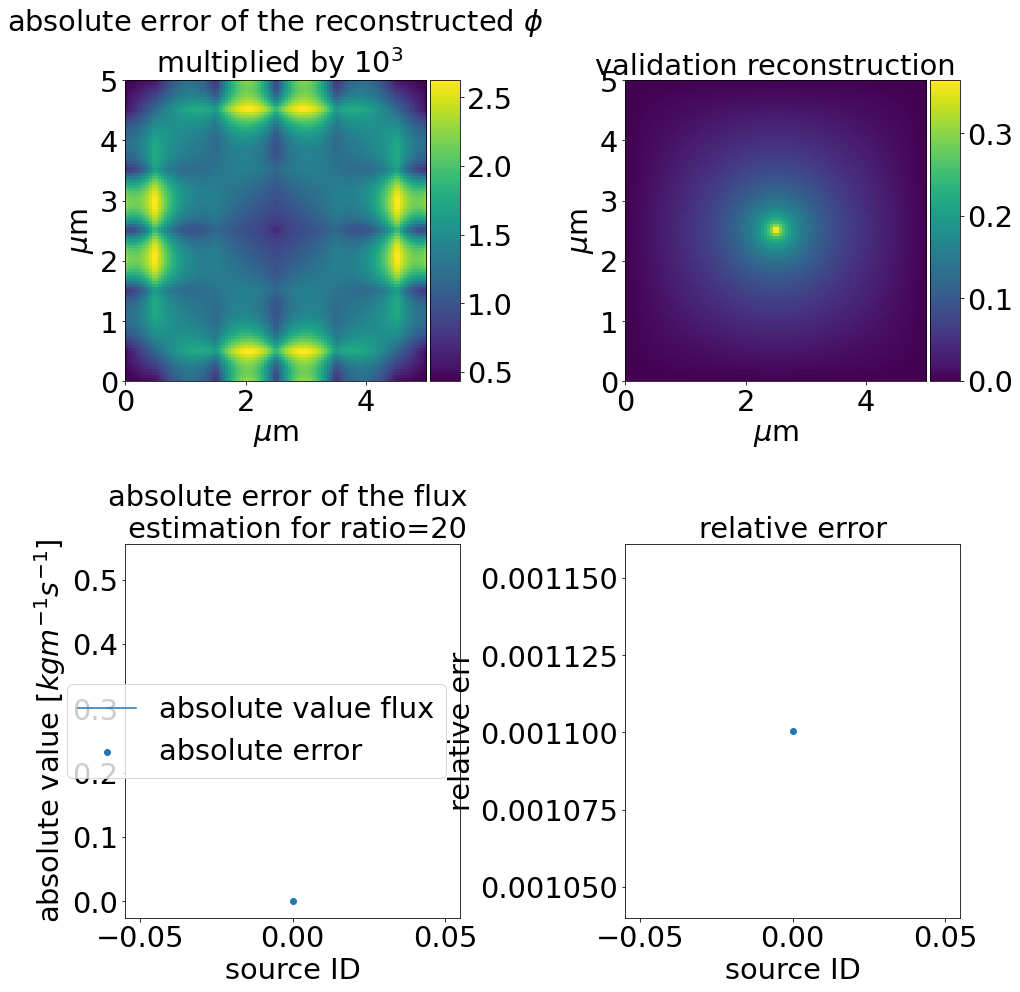

In [35]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
axs[1,0].scatter(np.arange(len(SS.phi_q)),np.abs(SS.phi_q-phi_q), label="absolute error")
axs[1,0].plot(SS.phi_q, label="absolute value flux")
axs[1,0].set_title("absolute error of the flux \n estimation for ratio={}".format(ratio))
axs[1,0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1,0].set_xlabel("source ID")
axs[1,0].legend()

d=axs[1,1].scatter(np.arange(len(SS.phi_q)),np.abs(SS.phi_q-phi_q)/np.abs(SS.phi_q))
axs[1,1].set_title("relative error")
axs[1,1].set_ylabel("relative err")
axs[1,1].set_xlabel("source ID")

b=axs[0,1].imshow(phi_SS, extent=[0,L,0,L],origin='lower')
axs[0,1].set_xlabel("$\mu$m")
axs[0,1].set_ylabel("$\mu$m")
axs[0,1].set_title("validation reconstruction")
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(b, cax=cax,orientation='vertical')

c=axs[0,0].imshow((a.rec_final-phi_SS)*1e3, extent=[0,L,0,L], origin='lower')
axs[0,0].set_xlabel("$\mu$m")
axs[0,0].set_ylabel("$\mu$m")
axs[0,0].set_title("absolute error of the reconstructed $\phi$ \n multiplied by $10^3$")
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(c, cax=cax,orientation='vertical')




In [36]:
pp=coord_to_pos(SS.x, SS.y, pos_s[0])
print(pp/len(SS.x))
pp=int(pp//len(SS.x))
print(pp)

50.5
50


In [37]:
len(SS.x)

100

L2 norm SS q= 0.001101759677380774
relative error with SS q=  0.001101759677380774
relative L2 norm with SS concentration field= 0.026482185578655597


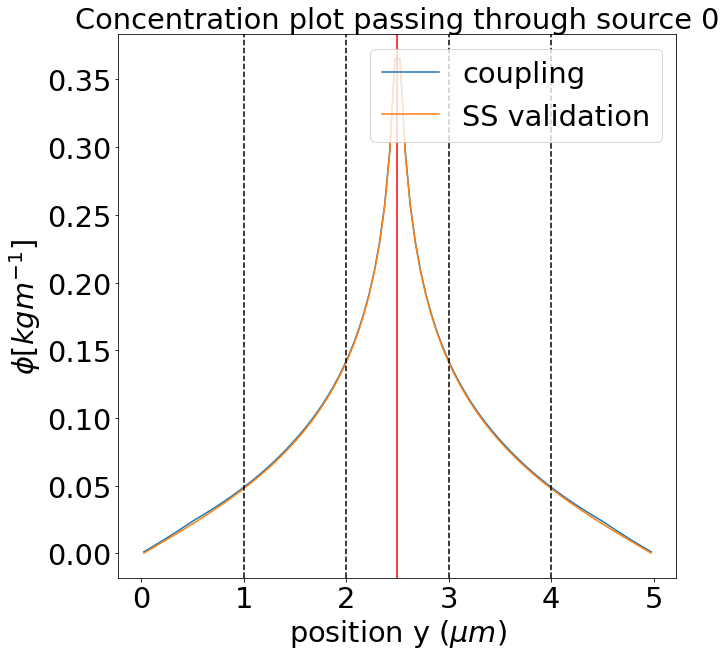

In [38]:
print("L2 norm SS q=",get_L2(a.phi_q, SS.phi_q))
print("relative error with SS q= ", get_MRE(a.phi_q, SS.phi_q))
print("relative L2 norm with SS concentration field=",get_L2(np.ndarray.flatten(phi_SS), np.ndarray.flatten(a.rec_final)))

get_plots_through_sources(a.rec_final, phi_SS, pos_s, SS.x, SS.y,t.y)




In [39]:
#comparison with no coupling
noc_sol, noc_lenx, noc_leny,noc_q, noc_B, noc_A, noc_s_blocks,noc_x,noc_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L,"nocup")

#comparison with Peaceman
p_sol, p_lenx, p_leny,p_q, p_B, p_A, p_s_blocks,p_x,p_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L)

errors=[["coupling","SS" , ratio , get_L2(SS.phi_q, phi_q) , get_L2(phi_SS, a.rec_final) , get_MRE(SS.phi_q, phi_q) , get_MRE(phi_SS, a.rec_final)],
        ["coupling","Peaceman", ratio,get_L2(p_q, phi_q), get_L2(p_sol, np.ndarray.flatten(a.rec_final)), get_MRE(p_q, phi_q), get_MRE(p_sol, np.ndarray.flatten(a.rec_final))],
        ["FV","SS",1,get_L2(SS.phi_q, noc_q), get_L2(np.ndarray.flatten(phi_SS), noc_sol), get_MRE(SS.phi_q, noc_q), get_MRE(np.ndarray.flatten(phi_SS), noc_sol)],
        ["FV","Peaceman",1,get_L2(p_q, noc_q), get_L2(p_sol, noc_sol), get_MRE(p_q, noc_q), get_MRE(p_sol, noc_sol)],
        ["Peaceman","SS", 1,get_L2(SS.phi_q, p_q), get_L2(np.ndarray.flatten(phi_SS), p_sol), get_MRE(SS.phi_q, p_q), get_MRE(np.ndarray.flatten(phi_SS), p_sol)]]
    

C_0=  1.0


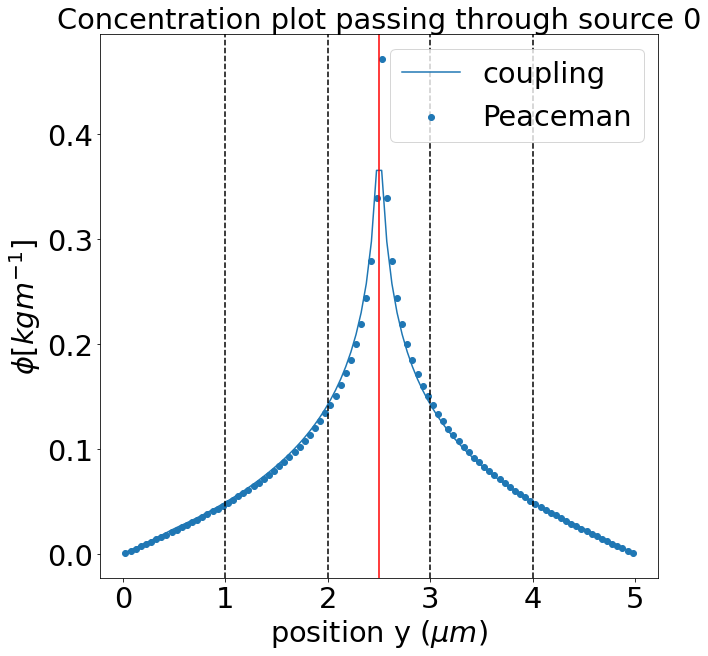

In [40]:
get_plots_through_sources_peaceman(a.rec_final,p_sol.reshape(len(p_y), len(p_x)),pos_s, p_x,p_y,t.y)

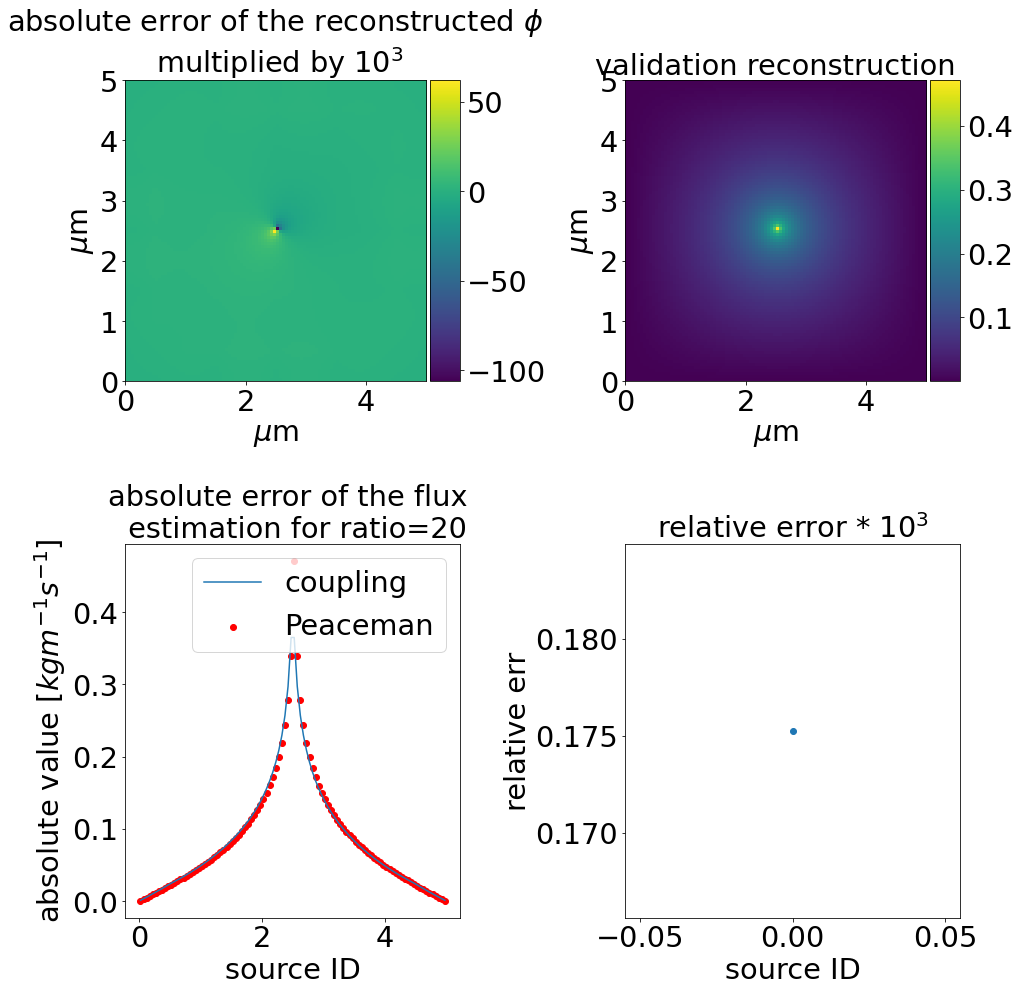

In [41]:
pos=coord_to_pos(SS.x, SS.y, pos_s[0])
pos_x=int(pos%len(SS.x))

p_sol_mat=p_sol.reshape(len(p_y), len(p_x))


fig, axs = plt.subplots(2,2, figsize=(15,15))
fig.tight_layout(pad=4.0)
axs[1,0].plot(SS.y, a.rec_final[:,pos_x], label="coupling")
axs[1,0].scatter(SS.y, p_sol_mat[:,pos_x], label="Peaceman", c='r')
axs[1,0].set_title("absolute error of the flux \n estimation for ratio={}".format(ratio))

axs[1,0].set_ylabel("absolute value [$kg m^{-1} s^{-1}$]")
axs[1,0].set_xlabel("source ID")
axs[1,0].legend()

d=axs[1,1].scatter(np.arange(len(p_q)),(1e3)*np.abs(p_q-phi_q)/np.abs(p_q))
axs[1,1].set_title("relative error * $10^{3}$")
axs[1,1].set_ylabel("relative err")
axs[1,1].set_xlabel("source ID")

b=axs[0,1].imshow(p_sol_mat, extent=[0,L,0,L],origin='lower')
axs[0,1].set_xlabel("$\mu$m")
axs[0,1].set_ylabel("$\mu$m")
axs[0,1].set_title("validation reconstruction")
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(b, cax=cax,orientation='vertical')

c=axs[0,0].imshow((a.rec_final-p_sol_mat)*1e3, extent=[0,L,0,L], origin='lower')
axs[0,0].set_xlabel("$\mu$m")
axs[0,0].set_ylabel("$\mu$m")
axs[0,0].set_title("absolute error of the reconstructed $\phi$ \n multiplied by $10^3$")
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(c, cax=cax,orientation='vertical')

In [42]:

print(tabulate(errors, headers=["Evaluated model","Validation", "ratio","L^2(q)", "L^2(phi)", "MRE(q)", "MRE(phi)"]))



Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupling           SS                 20  0.00110055    0.0264822  0.00110055    98.3918
coupling           Peaceman           20  0.000175247   0.0454322  0.000175247    0.191178
FV                 SS                  1  0.000925462   0.0403822  0.000925462    0.330874
FV                 Peaceman            1  0             0          0              0
Peaceman           SS                  1  0.000925462   0.0403822  0.000925462    0.330874


In [43]:
off_center=np.linspace(0,h_ss/2, 5)
mat_errors_peac=np.zeros([len(off_center), len(off_center)])
mat_errors_SS=np.zeros([len(off_center), len(off_center)])

for i in off_center:
    for j in off_center:
        pos_s=np.array([[0.5,0.5]])*L+np.array([i,j])
        S=len(pos_s)
        t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
        t.pos_arrays()
        t.initialize_matrices()
        M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
        t.B[-S:]=np.ones(S)*C0
        sol=np.linalg.solve(M, t.B)
        phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
        phi_q=sol[-S:]
        SS=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D, L)
        v_SS=SS.solve_problem(t.B[-S:])
        #comparison with no coupling
        noc_sol, noc_lenx, noc_leny,noc_q, noc_B, noc_A, noc_s_blocks,noc_x,noc_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L)

        #comparison with Peaceman
        p_sol, p_lenx, p_leny,p_q, p_B, p_A, p_s_blocks,p_x,p_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L)
        
        errors=[["coupling","SS" , ratio , get_L2(SS.phi_q, phi_q) , get_L2(phi_SS, a.rec_final) , get_MRE(SS.phi_q, phi_q) , get_MRE(phi_SS, a.rec_final)],
        ["coupling","Peaceman", ratio,get_L2(p_q, phi_q), get_L2(p_sol, np.ndarray.flatten(a.rec_final)), get_MRE(p_q, phi_q), get_MRE(p_sol, np.ndarray.flatten(a.rec_final))],
        ["FV","SS",1,get_L2(SS.phi_q, noc_q), get_L2(np.ndarray.flatten(phi_SS), noc_sol), get_MRE(SS.phi_q, noc_q), get_MRE(np.ndarray.flatten(phi_SS), noc_sol)],
        ["FV","Peaceman",1,get_L2(p_q, noc_q), get_L2(p_sol, noc_sol), get_MRE(p_q, noc_q), get_MRE(p_sol, noc_sol)],
        ["Peaceman","SS", 1,get_L2(SS.phi_q, p_q), get_L2(np.ndarray.flatten(phi_SS), p_sol), get_MRE(SS.phi_q, p_q), get_MRE(np.ndarray.flatten(phi_SS), p_sol)]]
    
        print("\n")
        print("ERROR FOR RELATIVE OFF-CENTERING. distance/h= {}".format(np.array([i,j])/h_ss))
        print(tabulate(errors, headers=["Evaluated model","Validation", "ratio","L^2(q)", "L^2(phi)", "MRE(q)", "MRE(phi)"]))
        mat_errors_SS[np.where(off_center==j)[0][0], np.where(off_center==i)[0][0]]=get_MRE(SS.phi_q, phi_q)
        mat_errors_peac[np.where(off_center==j)[0][0], np.where(off_center==i)[0][0]]=get_MRE(p_q, phi_q)

[0.52925826]
C_0=  1.0
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0. 0.]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupling           SS                 20  0.00110055    0.0264822  0.00110055    98.3918
coupling           Peaceman           20  0.000175247   0.0454322  0.000175247    0.191178
FV                 SS                  1  0.000925462   0.0403822  0.000925462    0.330874
FV                 Peaceman            1  0             0          0              0
Peaceman           SS                  1  0.000925462   0.0403822  0.000925462    0.330874
[0.52935513]
C_0=  1.0
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.    0.125]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupli

[0.53011019]
C_0=  1.0
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.25 0.25]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupling           SS                 20  0.00270841    0.0264822  0.00270841    98.3918
coupling           Peaceman           20  0.00193092    0.30871    0.00193092     0.346639
FV                 SS                  1  0.000778989   0.304229   0.000778989    0.48679
FV                 Peaceman            1  0             0          0              0
Peaceman           SS                  1  0.000778989   0.304229   0.000778989    0.48679
[0.53056124]
C_0=  1.0
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.25  0.375]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coup

[0.53252872]
C_0=  1.0
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.5 0.5]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupling           SS                 20  0.00727576    0.0264822  0.00727576    98.3918
coupling           Peaceman           20  0.00664869    0.516339   0.00664869     0.590617
FV                 SS                  1  0.000631263   0.490271   0.000631263    0.658632
FV                 Peaceman            1  0             0          0              0
Peaceman           SS                  1  0.000631263   0.490271   0.000631263    0.658632


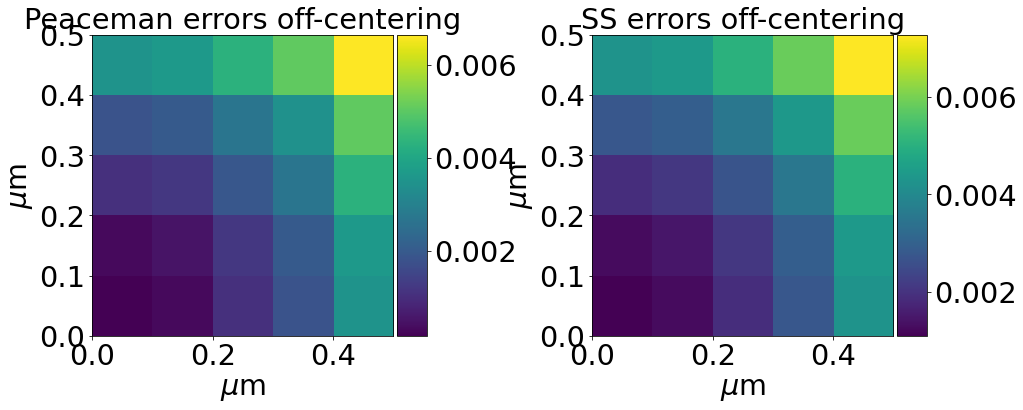

In [44]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)

b=axs[0].imshow(mat_errors_peac, extent=[0,h_ss/2,0,h_ss/2],origin='lower')
axs[0].set_xlabel("$\mu$m")
axs[0].set_ylabel("$\mu$m")
axs[0].set_title("Peaceman errors off-centering")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(b, cax=cax,orientation='vertical')

c=axs[1].imshow(mat_errors_SS, extent=[0,h_ss/2,0,h_ss/2], origin='lower')
axs[1].set_xlabel("$\mu$m")
axs[1].set_ylabel("$\mu$m")
axs[1].set_title("SS errors off-centering")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(c, cax=cax,  orientation='vertical')



In [45]:
off_center=np.linspace(0,h_ss*0.9, 5)+h_ss*0.05
mat_errors_peac=np.zeros([len(off_center), len(off_center)])
mat_errors_SS=np.zeros([len(off_center), len(off_center)])

for i in off_center:
    for j in off_center:
        pos_0=np.array([0.5,0.5])*L+np.array([1,1])*h_ss*0.45
        pos_s=np.array([pos_0,pos_0-np.array([i,j])])
        #pdb.set_trace()
        S=len(pos_s)
        t=assemble_SS_2D_FD(pos_s, Rv, h_ss,L, K_eff, D, directness)
        t.pos_arrays()
        t.initialize_matrices()
        M=t.assembly_sol_split_problem(np.array([0,0,0,0]))
        t.B[-S:]=np.ones(S)*C0
        sol=np.linalg.solve(M, t.B)
        phi_FV=sol[:-S].reshape(len(t.x), len(t.y))
        phi_q=sol[-S:]
        SS=full_ss(pos_s, Rv, h_ss/ratio, K_eff, D, L)
        v_SS=SS.solve_problem(t.B[-S:])
        #comparison with no coupling
        noc_sol, noc_lenx, noc_leny,noc_q, noc_B, noc_A, noc_s_blocks,noc_x,noc_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L)

        #comparison with Peaceman
        p_sol, p_lenx, p_leny,p_q, p_B, p_A, p_s_blocks,p_x,p_y=get_validation(ratio, t, pos_s, np.ones(S), D, K_eff, Rv, L, "Peaceman")
        
        errors=[["coupling","SS" , ratio , get_L2(SS.phi_q, phi_q) , get_L2(phi_SS, a.rec_final) , get_MRE(SS.phi_q, phi_q) , get_MRE(phi_SS, a.rec_final)],
        ["coupling","Peaceman", ratio,get_L2(p_q, phi_q), get_L2(p_sol, np.ndarray.flatten(a.rec_final)), get_MRE(p_q, phi_q), get_MRE(p_sol, np.ndarray.flatten(a.rec_final))],
        ["FV","SS",1,get_L2(SS.phi_q, noc_q), get_L2(np.ndarray.flatten(phi_SS), noc_sol), get_MRE(SS.phi_q, noc_q), get_MRE(np.ndarray.flatten(phi_SS), noc_sol)],
        ["FV","Peaceman",1,get_L2(p_q, noc_q), get_L2(p_sol, noc_sol), get_MRE(p_q, noc_q), get_MRE(p_sol, noc_sol)],
        ["Peaceman","SS", 1,get_L2(SS.phi_q, p_q), get_L2(np.ndarray.flatten(phi_SS), p_sol), get_MRE(SS.phi_q, p_q), get_MRE(np.ndarray.flatten(phi_SS), p_sol)]]
    
        print("\n")
        print("ERROR FOR RELATIVE OFF-CENTERING. distance/h= {}".format(np.array([i,j])/h_ss))
        print(tabulate(errors, headers=["Evaluated model","Validation", "ratio","L^2(q)", "L^2(phi)", "MRE(q)", "MRE(phi)"]))
        mat_errors_SS[np.where(off_center==j)[0][0], np.where(off_center==i)[0][0]]=get_MRE(SS.phi_q, phi_q)
        mat_errors_peac[np.where(off_center==j)[0][0], np.where(off_center==i)[0][0]]=get_MRE(p_q, phi_q)

[0.40834403 0.4077609 ]
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.05 0.05]
Evaluated model    Validation      ratio      L^2(q)    L^2(phi)      MRE(q)    MRE(phi)
-----------------  ------------  -------  ----------  ----------  ----------  ----------
coupling           SS                 20  0.0085843    0.0264822  0.00855401   98.3918
coupling           Peaceman           20  0.0103852    0.482827   0.0103571     0.322802
FV                 SS                  1  0.00182248   0.727835   0.00182196    1.02769
FV                 Peaceman            1  0            0          0             0
Peaceman           SS                  1  0.00182248   0.727835   0.00182196    1.02769
[0.44798579 0.44652033]
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.05  0.275]
Evaluated model    Validation      ratio      L^2(q)    L^2(phi)      MRE(q)    MRE(phi)
-----------------  ------------  -------  ----------  ----------  ----------  ----------
coupling           S

[0.47809563 0.47557693]
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.5 0.5]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coupling           SS                 20  0.00468823    0.0264822  0.00386662    98.3918
coupling           Peaceman           20  0.00423672    0.440716   0.0030089      0.393657
FV                 SS                  1  0.000919745   0.771142   0.000859322    1.33984
FV                 Peaceman            1  0             0          0              0
Peaceman           SS                  1  0.000919745   0.771142   0.000859322    1.33984
[0.48558437 0.48350696]
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.5   0.725]
Evaluated model    Validation      ratio       L^2(q)    L^2(phi)       MRE(q)    MRE(phi)
-----------------  ------------  -------  -----------  ----------  -----------  ----------
coup

[0.50003586 0.50061826]
C_0=  1.0


ERROR FOR RELATIVE OFF-CENTERING. distance/h= [0.95 0.95]
Evaluated model    Validation      ratio      L^2(q)    L^2(phi)      MRE(q)    MRE(phi)
-----------------  ------------  -------  ----------  ----------  ----------  ----------
coupling           SS                 20  0.00235796   0.0264822  0.00234957   98.3918
coupling           Peaceman           20  0.00124053   0.451791   0.00117927    0.420713
FV                 SS                  1  0.00130838   0.776638   0.00117145    1.44481
FV                 Peaceman            1  0            0          0             0
Peaceman           SS                  1  0.00130838   0.776638   0.00117145    1.44481


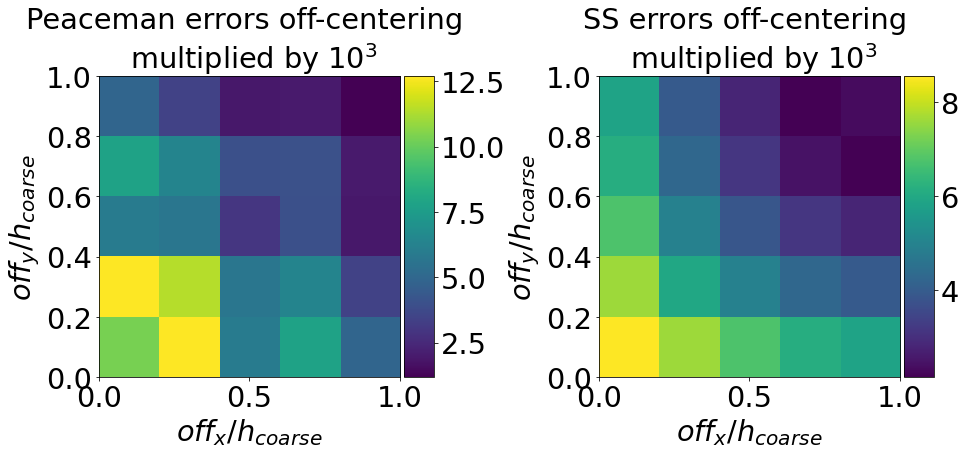

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
fig.tight_layout(pad=4.0)

b=axs[0].imshow(mat_errors_peac*1e3, extent=[0,1,0,1],origin='lower')
axs[0].set_xlabel("$off_x/h_{coarse}$")
axs[0].set_ylabel("$off_y/h_{coarse}$")
axs[0].set_title("Peaceman errors off-centering \n multiplied by $10^3$")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(b, cax=cax,orientation='vertical')

c=axs[1].imshow(mat_errors_SS*1e3, extent=[0,1,0,1], origin='lower')
axs[1].set_xlabel("$off_x/h_{coarse}$")
axs[1].set_ylabel("$off_y/h_{coarse}$")
axs[1].set_title("SS errors off-centering \n multiplied by $10^3$")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(c, cax=cax,  orientation='vertical')



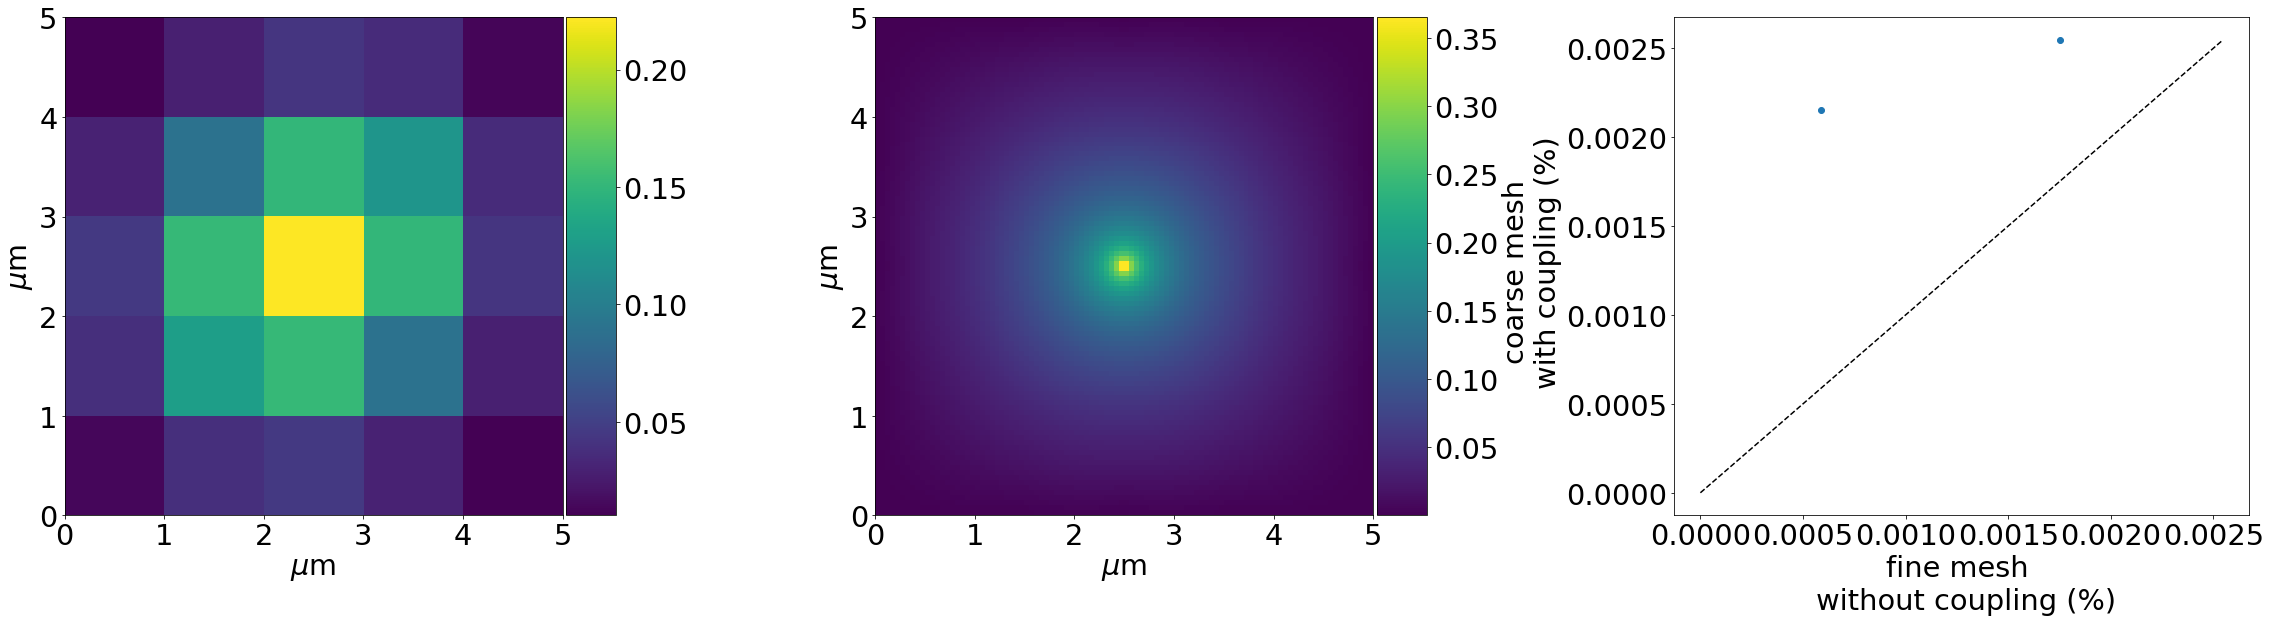

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

error_Peac=np.abs((SS.phi_q-p_q)/SS.phi_q)
error_FV=np.abs((SS.phi_q-noc_q)/SS.phi_q)
error_coup=np.abs((SS.phi_q-phi_q)/SS.phi_q)
fig, axs = plt.subplots(1,3, figsize=(18*2,6*2))
fig.tight_layout(pad=8.0)
axs[2].scatter(error_FV, error_coup)
axs[2].plot(np.linspace(0, np.max(error_coup)),np.linspace(0, np.max(error_coup)), 'k--')
axs[2].set_ylabel("coarse mesh \n with coupling (%)")
axs[2].set_xlabel("fine mesh \n without coupling (%)")


b=axs[1].imshow(a.rec_final, origin='lower', extent=[0,L,0,L])
axs[1].set_xlabel("$\mu$m")
axs[1].set_ylabel("$\mu$m")
#plt.title("reconstruction coupling")
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(b, cax=cax, orientation='vertical')

NN=post.coarse_NN_rec(t.x, t.y, phi_FV, pos_s, t.s_blocks, phi_q, ratio, h_ss, directness, Rv)

c=axs[0].imshow(NN, origin='lower', extent=[0,L,0,L])
axs[0].set_xlabel("$\mu$m")
axs[0].set_ylabel("$\mu$m")
#plt.title("average cell values")
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')